In [1]:
import os # miscellaneous operating system interfaces
import shutil # high-level file operations
import numpy as np
import cv2
import tensorflow as tf
import keras
import random
from itertools import product
from keras.models import Sequential 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 
from keras.layers import Flatten 
from keras.layers import Dense
from keras.layers import Dropout
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.layers import  Input, Conv2D, Conv2DTranspose, ReLU,AveragePooling2D, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K

base_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\man'

train_img_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\man\train'

test_img_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\man\test'

val_img_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\man\val'


learning_rate = 0.001
training_epochs = 20
batch_size = 512



print(f'batchSIZE is {batch_size}, Learning Rate is {learning_rate}')
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

categories = ['dog','cat','bear','hamster','horse']

training_set = train_datagen.flow_from_directory(train_img_dir, target_size=(128,128), 
                                             classes=categories, 
                                             batch_size=batch_size)

test_set = test_datagen.flow_from_directory(test_img_dir,
                                        target_size=(128,128), 
                                        classes=categories, 
                                        batch_size=batch_size)

val_set = test_datagen.flow_from_directory(val_img_dir,
                                        target_size=(128,128), 
                                        classes=categories, 
                                        batch_size=batch_size)

x_train, y_train = next(training_set)
x_test, y_test = next(test_set)
x_val,y_val = next(val_set)   

    

batchSIZE is 512, Learning Rate is 0.001
Found 580 images belonging to 5 classes.
Found 87 images belonging to 5 classes.
Found 213 images belonging to 5 classes.


In [2]:
def create_model():
    inputs = Input(shape=(128, 128, 3))
    

    conv2_1 = Conv2D(32, 3, 1, 'SAME')(inputs)
    conv2_2 = Conv2D(32, 3, 1, 'SAME')(conv2_1)
    pool2_3 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv2_2)
    br1 = BatchNormalization()(pool2_3)
    
    conv2_1 = Conv2D(32, 3, 1, 'SAME')(br1)
    conv2_2 = Conv2D(32, 3, 1, 'SAME')(conv2_1)
    pool2_3 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv2_2)
    br1 = BatchNormalization()(pool2_3)
    
    
    conv3_1 = Conv2D(64, 3, 1, 'SAME')(br1)
    conv3_2 = Conv2D(64, 3, 1, 'SAME')(conv3_1)
    pool3_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv3_2)
    br2 = BatchNormalization()(pool3_2)
    
    conv3_1 = Conv2D(64, 3, 1, 'SAME')(br2)
    conv3_2 = Conv2D(64, 3, 1, 'SAME')(conv3_1)
    pool3_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv3_2)
    br2 = BatchNormalization()(pool3_2)
    
    
    conv4_1 = Conv2D(128, 3, 1, 'SAME')(br2)
    conv4_2 = Conv2D(128, 3, 1, 'SAME')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv4_2)
    br3 = BatchNormalization()(pool4_2)
    
    conv4_1 = Conv2D(128, 3, 1, 'SAME')(br3)
    conv4_2 = Conv2D(128, 3, 1, 'SAME')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv4_2)
    br3 = BatchNormalization()(pool4_2)
    
    flatten1 = Flatten()(pool4_2)
    dense1 = Dense(units = 512, activation = 'relu')(flatten1)
    dense2 = Dense(units = 1024, activation = 'relu')(dense1)
    dr1 = Dropout(0.7)(dense2)
    dense3 = Dense(units = 5, activation = 'sigmoid')(dr1)
    
    return keras.Model(inputs=inputs, outputs=dense3) 
def mobile_net():
    inputs = Input(shape=(128, 128, 3))
    mobileNet = MobileNetV2(weights = "imagenet", include_top=False,input_shape = (128,128,3)
                            ,input_tensor = inputs)
#     for layer in mobileNet.layers:
#         layer.trainable = True
        
    output = mobileNet.output
    pooling = AveragePooling2D(pool_size=(4,4),padding='SAME')(output)
    
    flatten1 = Flatten()(pooling)
    dense1 = Dense(units = 512, activation = 'relu')(flatten1)
    dense2 = Dense(units = 1024, activation = 'relu')(dense1)
    dr1 = Dropout(0.7)(dense2)
    dense3 = Dense(units = 5, activation = 'sigmoid')(dr1)
    
    return keras.Model(inputs=inputs, outputs=dense3)

class ResidualUnit(tf.keras.Model):
    def __init__(self, filter_in, filter_out, kernel_size):
        super(ResidualUnit, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        if filter_in == filter_out:
            self.identity = lambda x: x
        else:
            self.identity = tf.keras.layers.Conv2D(filter_out, (1,1), padding='same')

    def call(self, x, training=False, mask=None):
        h = self.bn1(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv1(h)
        
        h = self.bn2(h, training=training)
        h = tf.nn.relu(h)
        h = self.conv2(h)
        return self.identity(x) + h
    
class ResnetLayer(tf.keras.Model):
    def __init__(self, filter_in, filters, kernel_size):
        super(ResnetLayer, self).__init__()
        self.sequence = list()
        for f_in, f_out in zip([filter_in] + list(filters), filters):
            self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x, training=training)
        return x
    
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu') # 28x28x8
        
        self.res1 = ResnetLayer(64, (16, 16), (3, 3)) # 28x28x16
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2)) # 14x14x16
        
        
        self.res2 = ResnetLayer(128, (32, 32), (3, 3)) # 14x14x32
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
    
        
        self.res3 = ResnetLayer(256, (64, 64), (3, 3)) # 7x7x64
        self.pool = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
        
        
        self.res4 = ResnetLayer(512, (64, 64), (3, 3)) # 7x7x64
        self.pool = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
        
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(1024, activation='relu')
        self.dense2 = tf.keras.layers.Dense(5, activation='softmax')
        
    def call(self, x, training=False, mask=None):
        x = self.conv1(x)
        
        x = self.res1(x, training=training)
        x = self.pool1(x)
        x = self.res2(x, training=training)
        x = self.pool2(x)
        x = self.res3(x, training=training)
        
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

In [3]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score



#model = create_model()
#model = ResNet()
model = mobile_net()


## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=training_epochs*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
model.compile(keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics=['accuracy', precision, recall, f1score])

# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy', 
#     metrics=['acc'],
# )




## Train!
history = model.fit(x_train, y_train, steps_per_epoch=training_epochs,
         epochs=150, validation_data = (x_val,y_val))

# epochs = 30
# history = model.fit(
#     training_set, 
#     epochs=epochs,
#     steps_per_epoch=training_set.samples / epochs, 
#     validation_data=val_set,
#     validation_steps=val_set.samples / epochs,
# )


Epoch 1/150
20/20 [==============================] - 16s 811ms/step - loss: 0.4528 - accuracy: 0.4824 - precision: 0.5910 - recall: 0.3455 - f1score: 0.4072 - val_loss: 0.5812 - val_accuracy: 0.4836 - val_precision: 0.7806 - val_recall: 0.1363 - val_f1score: 0.2230
Epoch 2/150
20/20 [==============================] - 15s 771ms/step - loss: 0.2821 - accuracy: 0.6855 - precision: 0.7549 - recall: 0.6391 - f1score: 0.6888 - val_loss: 1.2839 - val_accuracy: 0.3239 - val_precision: 0.5930 - val_recall: 0.1388 - val_f1score: 0.2225
Epoch 3/150
20/20 [==============================] - 16s 779ms/step - loss: 0.1879 - accuracy: 0.8301 - precision: 0.8545 - recall: 0.7861 - f1score: 0.8169 - val_loss: 0.8580 - val_accuracy: 0.5070 - val_precision: 0.8455 - val_recall: 0.2060 - val_f1score: 0.3275
Epoch 4/150
20/20 [==============================] - 16s 777ms/step - loss: 0.1617 - accuracy: 0.8613 - precision: 0.8938 - recall: 0.8415 - f1score: 0.8662 - val_loss: 1.4603 - val_accuracy: 0.3521 - v

Epoch 32/150
20/20 [==============================] - 15s 756ms/step - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 1.1271 - val_accuracy: 0.6103 - val_precision: 0.6507 - val_recall: 0.5821 - val_f1score: 0.6137
Epoch 33/150
20/20 [==============================] - 15s 761ms/step - loss: 0.0140 - accuracy: 0.9922 - precision: 0.9923 - recall: 0.9904 - f1score: 0.9913 - val_loss: 1.1300 - val_accuracy: 0.6197 - val_precision: 0.6641 - val_recall: 0.6133 - val_f1score: 0.6374
Epoch 34/150
20/20 [==============================] - 15s 760ms/step - loss: 0.0023 - accuracy: 0.9980 - precision: 0.9981 - recall: 0.9981 - f1score: 0.9981 - val_loss: 1.1292 - val_accuracy: 0.6244 - val_precision: 0.6636 - val_recall: 0.6267 - val_f1score: 0.6442
Epoch 35/150
20/20 [==============================] - 15s 758ms/step - loss: 0.0036 - accuracy: 0.9980 - precision: 0.9961 - recall: 0.9962 - f1score: 0.9961 - val_loss: 1.1279 - val_accuracy: 0.6291

20/20 [==============================] - 15s 747ms/step - loss: 3.8290e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.7331 - val_accuracy: 0.7606 - val_precision: 0.7627 - val_recall: 0.7562 - val_f1score: 0.7593
Epoch 63/150
20/20 [==============================] - 15s 747ms/step - loss: 0.0010 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.7173 - val_accuracy: 0.7653 - val_precision: 0.7719 - val_recall: 0.7651 - val_f1score: 0.7684
Epoch 64/150
20/20 [==============================] - 15s 740ms/step - loss: 4.2262e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.7021 - val_accuracy: 0.7746 - val_precision: 0.7770 - val_recall: 0.7740 - val_f1score: 0.7754
Epoch 65/150
20/20 [==============================] - 15s 740ms/step - loss: 6.9862e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.6881 - val_accuracy: 0.7746 

20/20 [==============================] - 15s 744ms/step - loss: 4.2116e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.4561 - val_accuracy: 0.8028 - val_precision: 0.8149 - val_recall: 0.7942 - val_f1score: 0.8043
Epoch 93/150
20/20 [==============================] - 15s 741ms/step - loss: 5.5197e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.4508 - val_accuracy: 0.8028 - val_precision: 0.8106 - val_recall: 0.7942 - val_f1score: 0.8022
Epoch 94/150
20/20 [==============================] - 15s 742ms/step - loss: 8.7505e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.4457 - val_accuracy: 0.7981 - val_precision: 0.8106 - val_recall: 0.7942 - val_f1score: 0.8022
Epoch 95/150
20/20 [==============================] - 15s 740ms/step - loss: 2.7085e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.4407 - val_accuracy: 0.7

20/20 [==============================] - 15s 742ms/step - loss: 4.2969e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.3622 - val_accuracy: 0.8263 - val_precision: 0.8276 - val_recall: 0.8144 - val_f1score: 0.8207
Epoch 123/150
20/20 [==============================] - 15s 734ms/step - loss: 3.4840e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.3605 - val_accuracy: 0.8263 - val_precision: 0.8276 - val_recall: 0.8144 - val_f1score: 0.8207
Epoch 124/150
20/20 [==============================] - 15s 737ms/step - loss: 0.0017 - accuracy: 0.9980 - precision: 0.9981 - recall: 0.9981 - f1score: 0.9981 - val_loss: 0.3589 - val_accuracy: 0.8263 - val_precision: 0.8276 - val_recall: 0.8144 - val_f1score: 0.8207
Epoch 125/150
20/20 [==============================] - 15s 735ms/step - loss: 4.4534e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1score: 1.0000 - val_loss: 0.3573 - val_accuracy: 0.82

87
index: 0  actual y: 1  answer y: 0  prediction: [0.72008985 0.21140423 0.04267049 0.00790787 0.0130344 ]
index: 1  actual y: 2  answer y: 2  prediction: [1.8396166e-13 1.0925489e-13 1.0000000e+00 9.1514253e-14 1.7638892e-13]
index: 2  actual y: 2  answer y: 2  prediction: [4.5380613e-13 3.6520795e-13 1.0000000e+00 2.7214542e-13 4.6183695e-13]
index: 3  actual y: 2  answer y: 2  prediction: [1.1493396e-10 7.8839796e-11 1.0000000e+00 1.0207708e-10 1.4951294e-10]
index: 4  actual y: 1  answer y: 1  prediction: [0.05147621 0.9102596  0.00316477 0.01586255 0.00324786]
index: 5  actual y: 0  answer y: 0  prediction: [0.39709967 0.01050156 0.01619026 0.0548684  0.33835733]
index: 6  actual y: 4  answer y: 4  prediction: [3.1112759e-07 1.0055430e-07 4.6422247e-07 1.0823626e-06 9.9999481e-01]
index: 7  actual y: 0  answer y: 0  prediction: [9.8376864e-01 2.9578354e-05 8.8989718e-06 2.2520304e-02 1.6936660e-04]
index: 8  actual y: 3  answer y: 4  prediction: [0.00273901 0.00720075 0.07261103 

3/3 [==============================] - 0s 72ms/step - loss: 0.1531 - accuracy: 0.8966 - precision: 0.9028 - recall: 0.8836 - f1score: 0.8930
loss: 0.153, accuracy: 0.897, precision: 0.903, recall: 0.884, f1score: 0.893


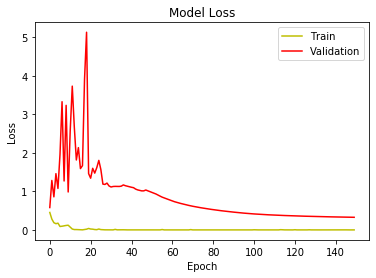

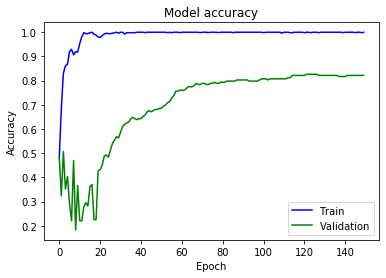

In [4]:
# output = classifier.predict_generator(test_set, steps=1)
# print(test_set.class_indices)
# print(output)
size = y_test[:,-1]
print(size.size)


# predict 10 random hand-writing data
y_predicted = model.predict(x_test)
for x in range(0,size.size):
    
    print("index:", x,
          " actual y:", np.argmax(y_test[x]),
          " answer y:", np.argmax(y_predicted[x]),
            " prediction:", np.array(y_predicted[x]))

_loss, _acc, _precision, _recall, _f1score = model.evaluate(x_test, y_test)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))
# print('loss: ', evaluation[0])
# print('accuracy', evaluation[1])

import matplotlib.pyplot as plt

# 손실 그래프
def plot_loss(history):
   # 선 그리기
    plt.plot(history.history['loss'], 'y', label='train loss')
    plt.plot(history.history['val_loss'], 'r', label='val loss')
   # 그래프 제목
    plt.title('Model Loss')
   # x,y축 이름 표시
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
   # 각 라인 표식 표시
    plt.legend(['Train','Validation'],loc=0)

# 정확도 그래프
def plot_acc(history):
  # dir(history.history)
    plt.plot(history.history['accuracy'], 'b', label='train accuracy')
    plt.plot(history.history['val_accuracy'], 'g', label='val accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc=0)

plot_loss(history)
plt.show()
plot_acc(history)
plt.show()

In [5]:
# batch_size = [512,1024]
# learning_rate = [0.001,0.0001,0.00001,0.000001]
# for  batch_size, learning_rate in product(batch_size,learning_rate):
#     print(f'batchSIZE is {batch_size}, Learning Rate is {learning_rate}')
#     train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

#     test_datagen = ImageDataGenerator(rescale = 1./255)

#     categories = ['dog','cat','bear','hamster','horse']

#     training_set = train_datagen.flow_from_directory(train_img_dir, target_size=(128,128), 
#                                                  classes=categories, 
#                                                  batch_size=batch_size)

#     test_set = test_datagen.flow_from_directory(test_img_dir,
#                                             target_size=(128,128), 
#                                             classes=categories, 
#                                             batch_size=batch_size)



#     x_train, y_train = next(training_set)
#     x_test, y_test = next(test_set)
#     model = mobile_net()
#     ## learning rate scheduing
#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
#                                                               decay_steps=training_epochs*10,
#                                                               decay_rate=0.4,
#                                                               staircase=True)
#     ## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
#     ## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
#     model.compile(keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

#     ## Train!
#     model.fit(x_train, y_train, steps_per_epoch=training_epochs,
#              epochs=20)
#     # output = classifier.predict_generator(test_set, steps=1)
#     # print(test_set.class_indices)
#     # print(output)
#     size = y_test[:,-1]
#     print(size.size)


#     # predict 10 random hand-writing data
#     y_predicted = model.predict(x_test)
#     for x in range(0,size.size):

#         print("index:", x,
#               " actual y:", np.argmax(y_test[x]),
#               " answer y:", np.argmax(y_predicted[x]),
#                 " prediction:", np.array(y_predicted[x]))

#     evaluation = model.evaluate(x_test, y_test)
#     print('loss: ', evaluation[0])
#     print('accuracy', evaluation[1])

